<div class="" style="margin-left: 20%">
    <h1> Machine learning</h1>
</div>
 

### Human cell sample records
In this notebook, I will build and train a model for human cell records and classify cells samples into whether they are benign or malignant using SVM (Support Vector Machines).

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

<h2>Table of contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Data source">Data source</a></li>
        <li><a href="#Exploratory">Exploratory Data Analysis</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Model Evaluation</a></li>
</ol>
</div>
<br>
<hr>

### Importing the necessary libraries for this notebook.

In [333]:
import pandas as pd
# import pylab as pl
import numpy as np
# import scipy.optimize as opt

# from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

<div id="Data source"><h2>Cancer Data Source</h2></div>

The samples is based on a dataset that is publicly available from the UCI Machine Learning Repository [Asuncion and Newman, 2007](http://mlearn.ics.uci.edu/MLRepository.html). The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. 

The original data analysis has shown significantly characteristics difference between benign and malignant samples. Using the SVM (Support Vector Machine)  classifier, we will train our model to understand patterns in the data that show, whether the sample is benign or malignant cells.
Once our model is trained, it will be able to predict new or unknown cell samples with a high level of accuracy.

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>


### Load Data From CSV File with ibm_boto3 and checking the head  

In [334]:
# The code was removed by Watson Studio for sharing.

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers.   
Characteristics of the cell samples from each patient are contained in fields Clump to Mit.   
The values are graded from 1 to 10, with 1 being the closest to benign.
The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).  

 <div id="Exploratory"><h2>Exploratory Data Analysis (EDA)</h2></div>

In [335]:
df.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Clump thickness and Uniformity
Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

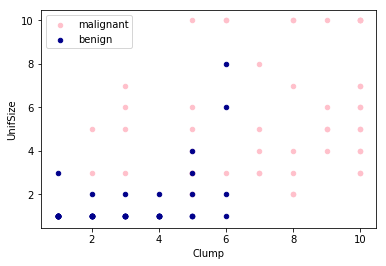

In [336]:
ax = df[df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='pink', label='malignant');
df[df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='benign', ax=ax);
plt.show()

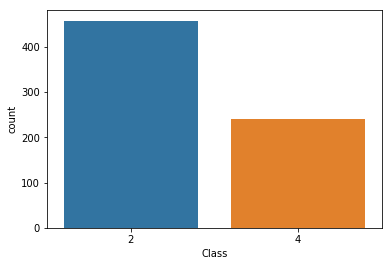

In [337]:
sns.countplot(x='Class',data=df)

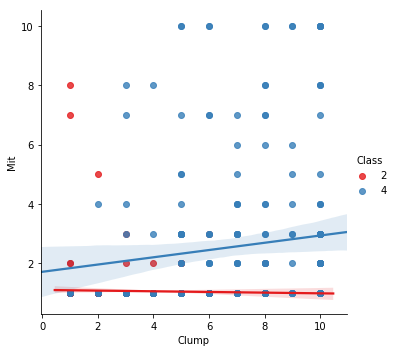

In [338]:
sns.lmplot(y='Mit',x='Clump',data=df,hue='Class',
          palette='Set1')

** This is not telling us much

## Data pre-processing and selection

For most part, our date is pretty clean, lets check our columns data types and make sure every column has numerical value.

In [339]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [340]:
df.dtypes['BareNuc']

dtype('O')


Our __BareNuc__ column appears to have a none numerical value. Let's convernt this to int for our model.

In [341]:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

It looks like every column has numerical value now

#### Let's set our features

In [342]:
#feature_df = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
feature_df = df.drop(['ID','Class'], axis=1)
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)).   
As this field can only have one of two possible values, we need to change its measurement level to reflect this.

In [343]:
df['Class'] = df['Class'].astype('int')
y = np.asarray(df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Now we can go ahead and split our dataset into train and test set:

In [344]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=101)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<div id="modeling"><h2>Modeling (SVM with Scikit-learn)</h2></div>

The SVM algorithm is set of supervised learning methods used for classification, regression and outliers detection. It provides an option of  kernel functions for performing its processing. It mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is called the kernel function, and the following are some of the different kinds:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid

For our model, we will use Linear and RBF (Radial Basis Function) kernel function and see which one performs better.

### Using RBF (Radial Basis Function)

In [345]:
model = svm.SVC(kernel='rbf')
model.fit(X_train, y_train) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [346]:
prediction = model.predict(X_test)
prediction [0:5]
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        95
           4       0.88      1.00      0.93        42

   micro avg       0.96      0.96      0.96       137
   macro avg       0.94      0.97      0.95       137
weighted avg       0.96      0.96      0.96       137



### Let's try Linear kernel

In [347]:
model1 = svm.SVC(kernel='linear')
model1.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

<div id="evaluation"><h2>Model Evaluation</h2></div>



In [348]:
pred = model1.predict(X_test)
pred [0:5]
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           2       0.96      1.00      0.98        95
           4       1.00      0.90      0.95        42

   micro avg       0.97      0.97      0.97       137
   macro avg       0.98      0.95      0.96       137
weighted avg       0.97      0.97      0.97       137



Now that our model has being fitted, It can be used to predict new or some unknown values:

#### Plot confusion matrix

Confusion matrix, without normalization
[[89  6]
 [ 0 42]]


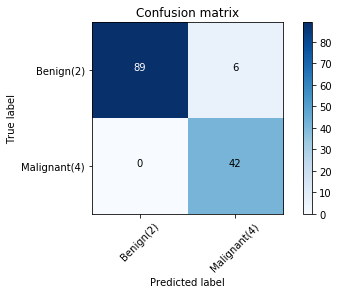

In [349]:
cnf_matrix = confusion_matrix(y_test, prediction, labels=[2,4])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [350]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

### Lets try jaccard index for accuracy:

In [351]:
print('\n')
print('RBF kernal (Radial Basis Function)')
print('Avg F1-score: %4f' % f1_score(y_test, prediction, average='weighted'))
print('Jaccard score: %4f' % jaccard_similarity_score(y_test, prediction))

print('\n')
print('Linear kernal')
print("Avg F1-score: %.4f" % f1_score(y_test, pred, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, pred))
print('\n')



RBF kernal (Radial Basis Function)
Avg F1-score: 0.956950
Jaccard score: 0.956204


Linear kernal
Avg F1-score: 0.9704
Jaccard score: 0.9708




### GridSearch
Our model is already performing well with high accuracy prediction. Let's see if we can tune the parameters to get better accuracy. For this, we will use GridSearchC to optimize the model.

In [352]:
from sklearn.model_selection import GridSearchCV

Creating a dictionary called param_grid and fill out some parameters for C and gamma.

In [353]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

Creating a GridSearchCV object and fit to the training data.

In [354]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... C=1, gamma=1, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

### Model Evaluation for GridSearchCV

In [355]:
grid_predictions = grid.predict(X_test)

In [356]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[94  1]
 [ 2 40]]
              precision    recall  f1-score   support

           2       0.98      0.99      0.98        95
           4       0.98      0.95      0.96        42

   micro avg       0.98      0.98      0.98       137
   macro avg       0.98      0.97      0.97       137
weighted avg       0.98      0.98      0.98       137



Confusion matrix, without normalization
[[94  1]
 [ 2 40]]


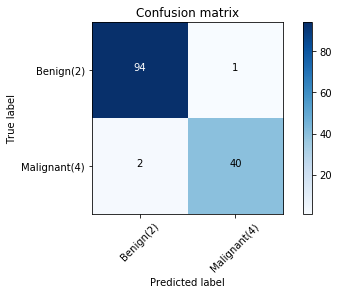

In [357]:
grid_matrix = confusion_matrix(y_test, grid_predictions, labels=[2,4])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(grid_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

#### Observation

It looks like we were able to improve our model from 97% to 98% accuracy across precision, recall, and f1-score.

In this notebook, we used SVM Kernel function Linear,RBF which is default SVM (Radial Basis function), and GridSearchCV, with respective prediction.

|Model|Accuracy|
|---|---|
|RBF|96%|
|Linear|97%|
|GridSearchCV|98%|
|Random Forest|99%|



#### Training the Random Forest model
I know I am overkilling this, but I decided to train a random forest model just to check. As you can see it returned an even better accuracy rate.

In [358]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)

In [359]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [360]:
rfc_predictions = rfc.predict(X_test)

In [361]:
print(classification_report(y_test,rfc_predictions))

              precision    recall  f1-score   support

           2       0.99      1.00      0.99        95
           4       1.00      0.98      0.99        42

   micro avg       0.99      0.99      0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137

